In [1]:
import os.path
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

KERAS_CHECKPOINT_FILE_PATH = 'keras.weights.best.hdf5'
KERAS_MODEL_WEIGHTS_FILE_PATH = 'keras.weights.h5'
TRAIN_DATA_FOLDER = "/data"
BATCH_SIZE = 128

Using TensorFlow backend.


### Data cleaning

In [2]:
def remove_zero_bias(data_frame):
    """
    Randomly deletes zero angle steering records to reduce zero angle bias.
    """
    rows_with_steering_zero = data_frame[(data_frame.steering == 0)]
    drop_indices = np.random.choice(rows_with_steering_zero.index,
                                    int(len(rows_with_steering_zero) * 0.7),
                                    replace=False)
    return data_frame.drop(drop_indices)

### Load track data

In [5]:
def process_data(directory, correction_factor, remove_bias=True):
    """
    Read the data csv file, generates image paths and measurements.
    """
    csv_file_path = directory + '/driving_log.csv'
    if not os.path.exists(csv_file_path):
        return []

    data_frame = pd.read_csv(csv_file_path,
                             names=['center', 'left', 'right',
                                    'steering', 'throttle', 'brake', 'speed'])

    if remove_bias:
        data_frame = remove_zero_bias(data_frame)

    processed_results = []
    images_dir = directory + '/IMG/'
    if not os.path.exists(images_dir):
        return processed_results

    for line in data_frame.itertuples():
        if float(line.speed) < 0.1:
            continue

        steering_center = float(line.steering)
        steering_left = steering_center+correction_factor
        steering_right = steering_center-correction_factor

        img_center_path = images_dir+line.center.split('/')[-1]
        img_left_path = images_dir+line.left.split('/')[-1]
        img_right_path = images_dir+line.right.split('/')[-1]

        processed_results.append((img_center_path, steering_center))
        processed_results.append((img_left_path, steering_left))
        processed_results.append((img_right_path, steering_right))

    return processed_results

### Data distribution

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


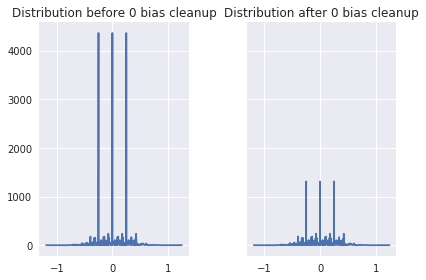

In [6]:
%matplotlib inline

samples = process_data('data', 0.25, remove_bias=False)
unique_rotation_angles, unique_rotation_angle_counts = np.unique([x[1] for x in samples], return_counts=True)

samples_wb = process_data('data', 0.25, remove_bias=True)
unique_rotation_angles_wb, unique_rotation_angle_counts_wb = np.unique([x[1] for x in samples_wb], return_counts=True)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(unique_rotation_angles, unique_rotation_angle_counts)
ax1.set_title('Distribution before 0 bias cleanup')
ax2.plot(unique_rotation_angles_wb, unique_rotation_angle_counts_wb)
ax2.set_title('Distribution after 0 bias cleanup')
f.tight_layout()

### Data/Image Augmentation 

In [14]:
# Credits to Vivek Yadav.
# Link: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
def random_brightness_image(image):
    """
    Returns an image with a random degree of brightness.
    """
    dst = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    dst = np.array(dst, dtype=np.float64)
    random_bright = .5+np.random.uniform()
    dst[:, :, 2] = dst[:, :, 2]*random_bright
    dst[:, :, 2][dst[:, :, 2] > 255] = 255
    dst = np.array(dst, dtype=np.uint8)
    dst = cv2.cvtColor(dst, cv2.COLOR_HSV2RGB)
    return dst

# Credits to Jeremy Shannon.
# Link: https://github.com/jeremy-shannon/CarND-Behavioral-Cloning-Project/blob/master/model.py#L110
def random_shift_image(image):
    '''
    Apply warp tranform the image
    '''
    h, w, _ = image.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8, h/8)
    pts1 = np.float32([[0, horizon], [w, horizon], [0, h], [w, h]])
    pts2 = np.float32([[0, horizon+v_shift], [w, horizon+v_shift], [0, h], [w, h]])
    return cv2.warpPerspective(image, cv2.getPerspectiveTransform(pts1, pts2),
                               (w, h), borderMode=cv2.BORDER_REPLICATE)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


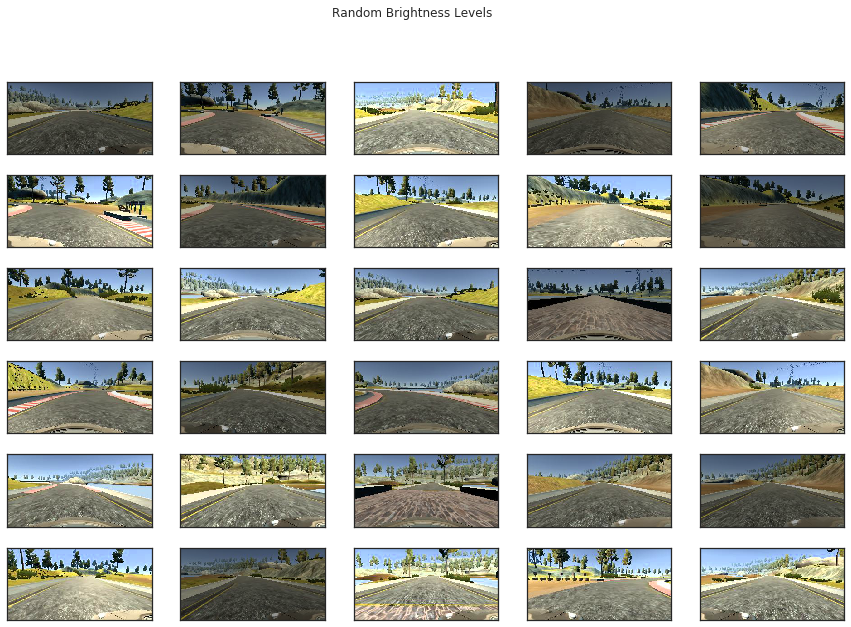

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 10.0)

# Pick 20 random track images
sub_samples = random.sample(samples, 30)

for c,sample in enumerate(sub_samples):
    with sns.axes_style("white"):
        plt.subplot(6,5,c+1)

    plt.tick_params(
        which='both', bottom='off', left='off', top='off', right='off', labelbottom='off', labelleft='off')
    plt.imshow(random_brightness_image(cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB)))

plt.suptitle('Random Brightness Levels')
plt.show()

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


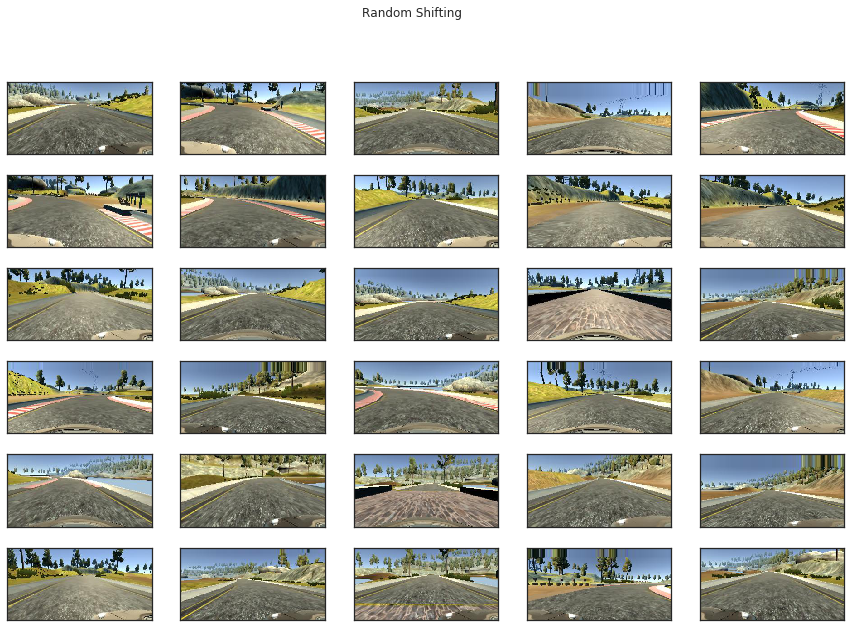

In [16]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 10.0)

for c,sample in enumerate(sub_samples):
    with sns.axes_style("white"):
        plt.subplot(6,5,c+1)

    plt.tick_params(
        which='both', bottom='off', left='off', top='off', right='off', labelbottom='off', labelleft='off')
    plt.imshow(random_shift_image(cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB)))

plt.suptitle('Random Shifting')
plt.show()

### Data Generator for train and validation data

In [17]:
def generator(samples, batch_size=32, validation=False):
    """
    Returns a generator for the required images and augmented images from the given set of samples.
    """
    num_samples = len(samples)

    while 1:
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            augmented_images, augmented_measurements = [], []

            for image_path, measurement in batch_samples:
                image = cv2.imread(image_path)
                image = cv2.GaussianBlur(image, (3, 3), 0)

                if not validation:
                    image = random_brightness_image(image)
                    image = random_shift_image(image)

                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                augmented_images.append(image)
                augmented_measurements.append(measurement)

                if abs(measurement) > 0.3:
                    image = cv2.flip(image, 1)
                    augmented_images.append(image)
                    augmented_measurements.append(measurement*-1.0)

                x_train = np.array(augmented_images)
                y_train = np.array(augmented_measurements)

                yield shuffle(x_train, y_train)
                x_train, y_train = [], []

### Preprocessing keras layers

In [11]:
def add_preprocessing_layers(model):
    """
    Apply some common data preprocessing layers to the keras model.
    """
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))

### Neural Network with LeNET Architecture

In [12]:
def lenet_arch_model():
    """
    Returns the keras model for the LENET architecture.
    """
    model = Sequential()
    add_preprocessing_layers(model)

    model.add(Convolution2D(6, kernel_size=(5, 5), padding="valid",
                            activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(16, kernel_size=(5, 5), padding="valid",
                            activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(120, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.65))
    model.add(Dense(84, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.65))
    model.add(Dense(1))

    return model

### Neural Network with NVIDIA Architecture

In [13]:
def nvidia_arch_model():
    """
    Returns the keras model for the popular NVIDIA architecture.
    """
    model = Sequential()
    add_preprocessing_layers(model)

    model.add(Convolution2D(24, 5, strides=(2, 2), kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(36, 5, strides=(2, 2), kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, strides=(2, 2), kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64, (3, 3), kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64, (3, 3), kernel_regularizer=l2(0.001)))
    model.add(ELU())

    model.add(Flatten())
    model.add(Dense(100, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(50, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(10, kernel_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Dense(1))

    return model

### Compile and Train the model

In [ ]:
### Splitting samples and creating generators.
data_samples = process_data(os.path.dirname(os.path.realpath('__file__'))+TRAIN_DATA_FOLDER, 0.25)
train_samples, validation_samples = train_test_split(data_samples, test_size=0.2)

### Create seperate generators for training and validation data
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE, validation=True)

### Create a keras model
keras_model = nvidia_arch_model()


### Load any previous saved model weights, if exists
if os.path.exists(KERAS_MODEL_WEIGHTS_FILE_PATH):
    keras_model.load_weights(KERAS_MODEL_WEIGHTS_FILE_PATH)
else:
    print("No prior saved model weights exist")

### Compile and train the model using the generator function
keras_model.compile(loss='mse', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

history_object = keras_model.fit_generator(train_generator,
                                           steps_per_epoch=int(np.floor((len(train_samples))
                                                                        /BATCH_SIZE)*BATCH_SIZE),
                                           validation_data=validation_generator,
                                           validation_steps=int(np.floor((len(validation_samples))
                                                                         /BATCH_SIZE)*BATCH_SIZE),
                                           epochs=5,
                                           verbose=1,
                                           callbacks=[ModelCheckpoint(KERAS_CHECKPOINT_FILE_PATH,
                                                                      verbose=1,
                                                                      save_best_only=True)])

keras_model.save_weights(KERAS_MODEL_WEIGHTS_FILE_PATH)
keras_model.save('model.h5')

### Test the model

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


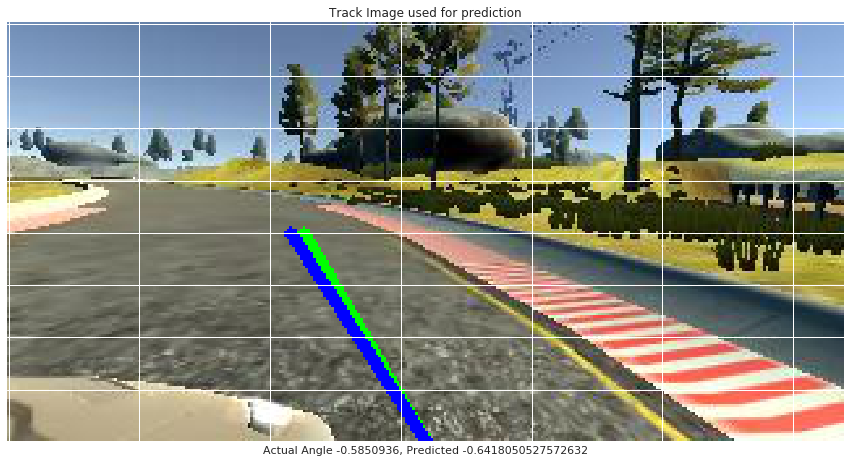

In [26]:
from keras.models import load_model as load_keras_model

if not os.path.exists('model.h5'):
    print("File {} not found!".format(model_filename))
    exit

keras_model = load_keras_model('model.h5')

random_sample = random.sample(samples, 1)[0]
measurement = random_sample[1]
image = cv2.cvtColor(cv2.imread(random_sample[0]), cv2.COLOR_BGR2RGB)
image_array = np.asarray(image)           
predicted_measurement = keras_model.predict(image_array[None, :, :, :], batch_size=1)[0][0]

h,w = image.shape[0:2]
cv2.line(image,(int(w/2),int(h)),(int(w/2+measurement*w/4),int(h/2)),(0,255,0),thickness=4)
cv2.line(image,(int(w/2),int(h)),(int(w/2+predicted_measurement*w/4),int(h/2)),(0,0,255),thickness=4)
        
plt.figure()
plt.rcParams['figure.figsize'] = (15.0, 10.0)

plt.title("Track Image used for prediction")
plt.tick_params(which='both', bottom='off', left='off', top='off', right='off', labelbottom='off', labelleft='off')
plt.imshow(image)
plt.xlabel('Actual Angle {}, Predicted {}'.format(measurement, predicted_measurement))

### Visualize a Keras Network Model

In [14]:
def visualize_model_loss(hist_object):
    """
    Visualize the loss metrics for the keras model .
    """
    plt.plot(hist_object.history['loss'])
    plt.plot(hist_object.history['val_loss'])
    plt.title('Mean Squared Error Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')

    plt.show()